In [ ]:
# Mount Google Drive - 

from google.colab import drive

drive.mount("/content/drive")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
os.chdir("/content/drive/MyDrive/Fallabella_interview")

In [ ]:
# Use unzip to extract data
#!unzip  train_test_reviews.zip

In [ ]:
# Install wandb
!pip install --upgrade wandb
!wandb login 27a7da33c576ce666efe01b380e6d9b2f8a63119
import wandb
from wandb.keras import WandbCallback
wandb.init(project="fallabella_sentiment_classification")

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


wandb: Currently logged in as: udaygirish (use `wandb login --relogin` to force relogin)


In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense,Embedding,Conv1D,MaxPooling1D,LSTM,Bidirectional
from keras.layers import Dropout,Flatten,BatchNormalization,LeakyReLU
from keras.layers import LSTM
from keras.layers import RNN
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils
from keras import *
import keras
from keras.preprocessing import sequence
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re
import nltk
nltk.download('stopwords')
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import GlobalMaxPooling1D,MaxPool1D
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
from keras import backend as K

def recall_m(y_true, y_pred):
  true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
  possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
  recall = true_positives / (possible_positives + K.epsilon())
  return recall

def precision_m(y_true, y_pred):
  true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
  predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
  precision = true_positives / (predicted_positives + K.epsilon())
  return precision

def f1_m(y_true, y_pred):
  precision = precision_m(y_true, y_pred)
  recall = recall_m(y_true, y_pred)
  return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
df_train_path = "reviews_training_26000.csv"
df_test_path = "reviews_test_4000.csv"

In [ ]:
df_train = pd.read_csv(df_train_path)
df_test = pd.read_csv(df_test_path)

In [ ]:
# Check first 20 records of df_train
df_train.head(20)

,review_id,review,sentiment
0,2,I thought this was a wonderful way to spend ti...,positive
1,3,Basically there's a family where a little boy ...,negative
2,7,"This show was an amazing, fresh & innovative i...",negative
3,8,Encouraged by the positive comments about this...,negative
4,10,Phil the Alien is one of those quirky films wh...,negative
5,11,I saw this movie when I was about 12 when it c...,negative
6,12,So im not a big fan of Boll's work but then ag...,negative
7,13,The cast played Shakespeare.<br /><br />Shakes...,negative
8,15,"Kind of drawn in by the erotic scenes, only to...",negative
9,17,This movie made it into one of my top 10 most ...,negative


In [ ]:
# Check first 20 records of test data
df_test.head(20)

,review_id,review,sentiment
0,T_0,I have to confess that I am severely disappoin...,negative
1,T_9,I have never understood the appeal of this sho...,negative
2,T_12,This is supposed to be based on Wilkie Collins...,negative
3,T_13,Of all the British imperialist movies like Fou...,positive
4,T_15,I loved this film. Not being a swooning Ed Woo...,positive
5,T_16,"Having already seen the original ""Jack Frost"",...",negative
6,T_21,"When the Romulans come, they will not be beari...",positive
7,T_24,"I wasn't really interested in seeing Step Up, ...",negative
8,T_31,"Over Christmas break, a group of college frien...",negative
9,T_34,The pilot is extremely well done. It lays out ...,positive


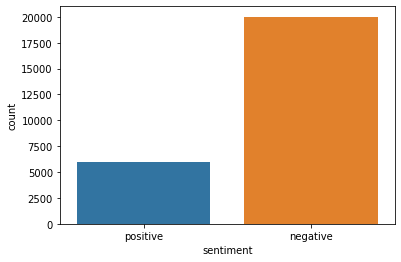

In [ ]:
# Visualise the Positive and negative counts in Train set
sns.countplot(x='sentiment', data=df_train)

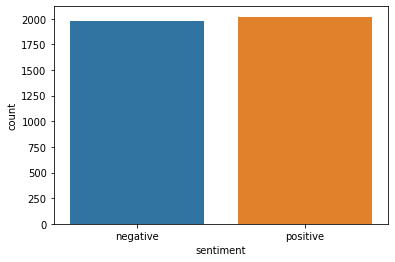

In [ ]:
# Visualise the Positive and negative counts in Test set
sns.countplot(x='sentiment', data=df_test)

In [ ]:
df_labelled_train = df_train.replace({'sentiment' : { 'positive' : 0, 'negative' : 1 }})
df_labelled_test = df_test.replace({'sentiment' : { 'positive' : 0, 'negative' : 1 }})

In [ ]:
df_labelled_train.head()

,review_id,review,sentiment
0,2,I thought this was a wonderful way to spend ti...,0
1,3,Basically there's a family where a little boy ...,1
2,7,"This show was an amazing, fresh & innovative i...",1
3,8,Encouraged by the positive comments about this...,1
4,10,Phil the Alien is one of those quirky films wh...,1


In [ ]:
df_labelled_test.head()

,review_id,review,sentiment
0,T_0,I have to confess that I am severely disappoin...,1
1,T_9,I have never understood the appeal of this sho...,1
2,T_12,This is supposed to be based on Wilkie Collins...,1
3,T_13,Of all the British imperialist movies like Fou...,0
4,T_15,I loved this film. Not being a swooning Ed Woo...,0


In [ ]:
def preprocess_text(sen):
  sentence = remove_tags(sen)
  sentence = re.sub('[^a-zA-Z]', ' ', sentence)
  sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)
  sentence = re.sub(r'\s+', ' ', sentence)
  return sentence

In [ ]:
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    return TAG_RE.sub('', text)

In [ ]:
X = []
sentences = list(df_labelled_train['review'])
for sen in sentences:
    X.append(preprocess_text(sen))

In [ ]:
y = df_labelled_train['sentiment'].tolist()

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20,random_state=12)

In [ ]:
X_train[0]

'Ah yet another Seagal movie In no less than few mere months arrive to populate the video store shelves As bad as Submerged No But that is not saying much Like perfume on pig Seagal is professional thief who wants to quit but goes for one last job only to be double crossed by his boss He lands in Prison and is befriended by Gangster who helps him to break out and seek payback Its good to see Seagal finally not playing an agent cop or what he usually plays We actually get USA Location in Las Vegas it seems Then an eastern European territory as usual There is no wire Fu either here Don Fauntleroy does an okay job However most of the action and fight scenes with Stevie are clearly doubles Scenes from other movies lack of realism and logic in even tiniest situation Seagal and Treech make so so team inspiring unintentional laughs one minute Sighs the rest Several notable faces turn up to slum it sleepy Kevin Tighe is long way from his emergency days Nick Mancuso shows up in sleepwalking mod

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [ ]:
X_train_1 = tokenizer.texts_to_sequences(X_train)
X_test_1 = tokenizer.texts_to_sequences(X_test)

In [ ]:
from keras.preprocessing import sequence
# truncate and pad input sequences
max_review_length = 100
X_train_3 = sequence.pad_sequences(X_train_1, maxlen=max_review_length)
X_test_3 = sequence.pad_sequences(X_test_1, maxlen=max_review_length)


In [ ]:
vectorizer = TfidfVectorizer(min_df=2, ngram_range=(1, 2), stop_words='english', max_features= 10000,strip_accents='unicode', norm='l2')
X_train_2 = vectorizer.fit_transform(X_train).todense()
X_test_2 = vectorizer.transform(X_test).todense()

In [ ]:
print("XTrain Shape:{}".format(X_train_3.shape))
print("XTest Shape:{}".format(X_test_3.shape))

XTrain Shape:(20804, 100)
XTest Shape:(5201, 100)


In [ ]:
 #Logistic Regression based classification
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(X_train_2, y_train)
score = model.score(X_test_2, y_test)
print(score)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:590: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


0.8957892712939819


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:590: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


In [ ]:
X_test_main = []
sentences = list(df_labelled_test['review'])
for sen in sentences:
    X_test_main.append(preprocess_text(sen))
  
y_test_main = df_labelled_test['sentiment'].tolist()

X_test_main_1 = vectorizer.transform(X_test_main).todense()
X_test_main_2 = tokenizer.texts_to_sequences(X_test_main)
X_test_main_3 = sequence.pad_sequences(X_test_main_2, maxlen=max_review_length)

In [ ]:
score = model.score(X_test_main_1, y_test_main)
print(score)

0.811


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:590: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


In [ ]:
X_train_3  = np.array(X_train_3)
X_test_3  = np.array(X_test_3)

y_train  = np.array(y_train)
y_test  = np.array(y_test)

In [ ]:
def create_model():
  top_words=100000
  embedding_vector_length = 32
  model = Sequential()
  model.add(Embedding(top_words, embedding_vector_length, input_length=max_review_length))
  model.add(Conv1D(filters=32, kernel_size=3, padding='same'))
  model.add(LeakyReLU(alpha=0.001))
  model.add(BatchNormalization())
  # model.add(Conv1D(filters=128, kernel_size=3, padding='same'))
  # model.add(LeakyReLU(alpha=0.001))
  # model.add(BatchNormalization())
  model.add(MaxPooling1D(pool_size=2,padding='same'))
  model.add(Dropout(0.4))
  model.add(Bidirectional(LSTM(128,)))  
  model.add(BatchNormalization())
  #model.add(Dropout(0.3))
  model.add(Dense(256, activation='leaky_relu'))
  model.add(Dense(64,activation='relu'))
  model.add(Dropout(0.3))
  model.add(Dense(10, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))
  return model

In [ ]:
wandb.init(project="fallabella_sentiment_classification")

In [ ]:

# create the model
# Model includes 1 Convolution 1 Dimensional layer for feature selection and one
#max pool layer for feature refining and then the output will be passed to LSTM
#layer which then outputs it to a dense layer  with relu for non linearity addition 
# and then to a dense layer with sigmoid for classification into positive and negative
#sentiment classes

model = create_model()
#opt = keras.optimizers.Adagrad()
adam = tf.keras.optimizers.Adam(lr=0.0001, decay=1e-6, clipnorm=1.)
model.compile(loss='binary_crossentropy', optimizer= adam, metrics=['accuracy',f1_m, precision_m,recall_m])
print(model.summary())
filepath="weights_best_cnn3_new_2CNN_final.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_precision_m', verbose=1, save_best_only=True, mode='max',save_weights_only=True)
callbacks_list = [checkpoint,WandbCallback()]
H = model.fit(X_train_3, y_train, epochs=30, batch_size=128,verbose = 1,callbacks = callbacks_list,validation_data=(X_test_3,y_test))

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 32)           3200000   
                                                                 
 conv1d_2 (Conv1D)           (None, 100, 32)           3104      
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 100, 32)           0         
                                                                 
 batch_normalization_4 (Batc  (None, 100, 32)          128       
 hNormalization)                                                 
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 50, 32)           0         
 1D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 50, 32)           

In [ ]:
model = create_model()
model_cnn = model.load_weights("weights_best_cnn3_new_2CNN_final.hdf5")

In [ ]:
y_pred = model.predict(np.array(X_test_main_3))

In [ ]:
y_pred_mod = [1 if i>0.5 else 0 for i in y_pred]

In [ ]:
accuracy = accuracy_score(y_pred_mod, y_test_main)

In [ ]:
print(accuracy)

0.8325


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

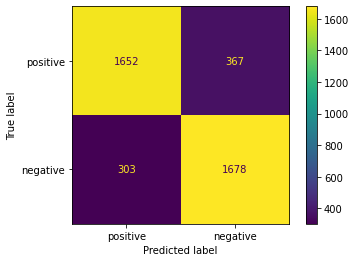

In [ ]:
cm = confusion_matrix(y_test_main, y_pred_mod, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['positive','negative'])
disp.plot()
plt.show()

In [ ]:
y_train_pred = model.predict(np.array(X_train_3))
y_train_pred_mod = [1 if i>0.5 else 0 for i in y_train_pred]

In [ ]:
accuracy = accuracy_score(y_train_pred_mod, y_train)
print(accuracy)

0.989713516631417


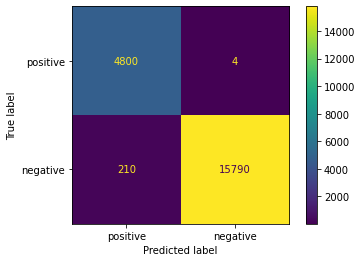

In [ ]:
cm = confusion_matrix(y_train, y_train_pred_mod, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['positive','negative'])
disp.plot()
plt.show()